# Training scripts V2

This script contains many different pieces/steps of the model training

## Loading the dataset
Prepared from the dataset_cleaning script

In [2]:
import pandas as pd

filepath = "final_dataset.csv"

final_dataset = pd.read_csv(filepath)

## Additional dataset preparation (sort life expectancy ascending)

In [3]:
final_dataset = final_dataset.sort_values(by=['Life Expectancy'])

## Additional dataset preparation (stratified split)

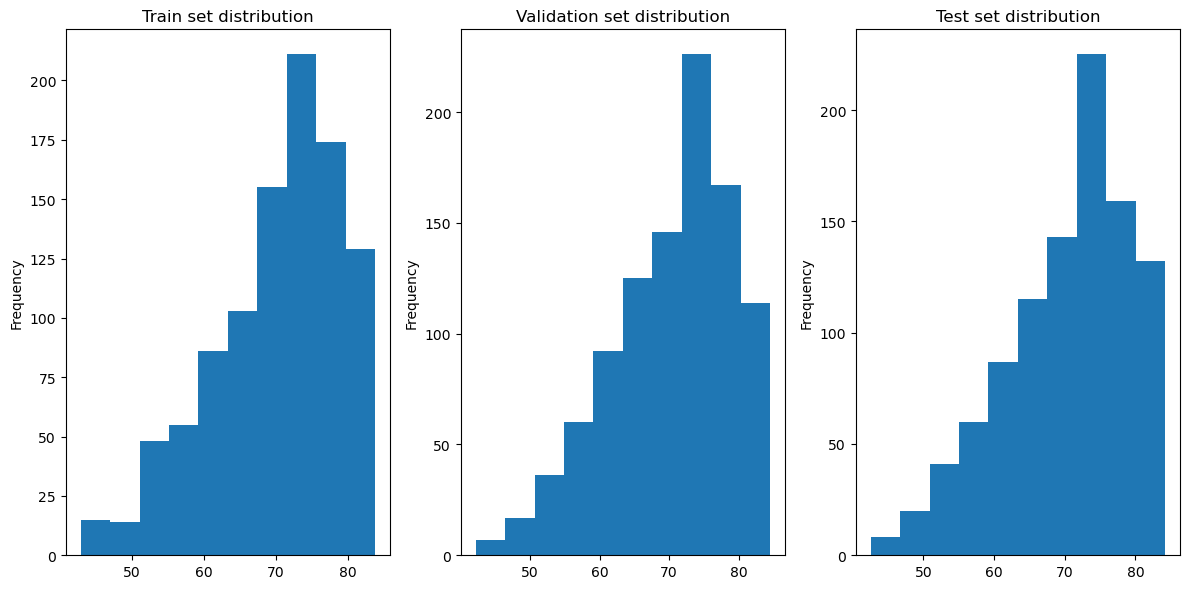

In [4]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define the target variable
target = 'Life Expectancy'

# Stratify bins for the target variable to ensure distribution
# Creating bins to stratify the target variable
num_bins = 10
final_dataset['stratify_bins'] = pd.qcut(final_dataset[target], q=num_bins, duplicates='drop')

# Step 1: Split data into train_temp (2/3 of data) and test (1/3 of data)
train_temp, test = train_test_split(
    final_dataset,
    test_size=1/3,
    stratify=final_dataset['stratify_bins'],
    random_state=42
)

# Step 2: Split train_temp into train (1/2 of remaining data) and validation (1/2 of remaining data)
train, validation = train_test_split(
    train_temp,
    test_size=0.5,
    stratify=train_temp['stratify_bins'],
    random_state=42
)

# Remove the helper stratification column
train = train.drop(columns=['stratify_bins'])
validation = validation.drop(columns=['stratify_bins'])
test = test.drop(columns=['stratify_bins'])

# plot the distribution of the target variable in the train, validation, and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
train[target].plot.hist(title='Train set distribution')
plt.subplot(1, 3, 2)
validation[target].plot.hist(title='Validation set distribution')
plt.subplot(1, 3, 3)
test[target].plot.hist(title='Test set distribution')
plt.tight_layout()
plt.show()


# Split the dataset

In [5]:
# column 1 to end are features, column 0 is the target
X_train = train[train.columns[1:]]
y_train = train[train.columns[0]]

X_test = test[test.columns[1:]]
y_test = test[test.columns[0]]

X_val = validation[validation.columns[1:]]
y_val = validation[validation.columns[0]]

## Train a simple decision tree


In [6]:
from sklearn import tree
from sklearn.metrics import mean_squared_error

# tree depth = 4
tree_depth = 4
model = tree.DecisionTreeRegressor(max_depth=tree_depth)
model.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

## Random forest model training

In [42]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=100, max_depth=4)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=4)

# XGBoost model training


## Grid parameter search?

In [ ]:
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
dval = xgb.DMatrix(X_val, label=y_val)

# https://xgboost.readthedocs.io/en/latest/parameter.html
params = {
    'max_depth': 3,
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'booster': 'dart',
}
# train the model
model = xgb.train(params, dtrain, num_boost_round=50, evals=[(dtest, 'test'), (dval, 'val')], early_stopping_rounds=10)

[0]	test-rmse:6.40745	val-rmse:6.37164
[1]	test-rmse:4.83676	val-rmse:4.82743
[2]	test-rmse:3.77510	val-rmse:3.73423
[3]	test-rmse:3.09265	val-rmse:3.04261
[4]	test-rmse:2.67278	val-rmse:2.60158
[5]	test-rmse:2.42294	val-rmse:2.30575
[6]	test-rmse:2.26182	val-rmse:2.11705
[7]	test-rmse:2.14294	val-rmse:2.02182
[8]	test-rmse:2.07355	val-rmse:1.94787
[9]	test-rmse:2.03891	val-rmse:1.91238
[10]	test-rmse:2.01118	val-rmse:1.87992
[11]	test-rmse:1.98945	val-rmse:1.83966
[12]	test-rmse:1.96072	val-rmse:1.82480
[13]	test-rmse:1.95612	val-rmse:1.81391
[14]	test-rmse:1.92238	val-rmse:1.79136
[15]	test-rmse:1.92042	val-rmse:1.78644
[16]	test-rmse:1.91153	val-rmse:1.78042
[17]	test-rmse:1.88640	val-rmse:1.76054
[18]	test-rmse:1.88273	val-rmse:1.74703
[19]	test-rmse:1.88263	val-rmse:1.74392
[20]	test-rmse:1.87531	val-rmse:1.74531
[21]	test-rmse:1.86710	val-rmse:1.73760
[22]	test-rmse:1.86331	val-rmse:1.73185
[23]	test-rmse:1.86291	val-rmse:1.73338
[24]	test-rmse:1.86201	val-rmse:1.72797
[25]	test-

# Model validation


<class 'xgboost.core.Booster'>
Test MSE: 3.8078207306897913
Validation MSE: 3.401663656586999
R-sq: 0.9499708658228905
Validation R-sq: 0.9545181530895794


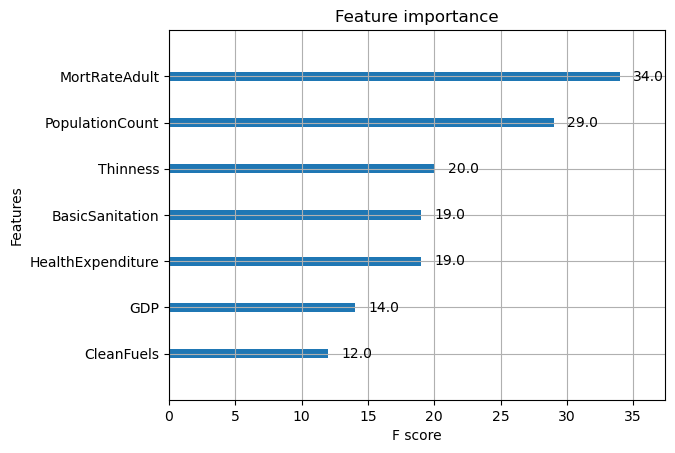

In [17]:
# test model
print(type(model))
if(type(model) == xgb.core.Booster):
    y_pred = model.predict(dtest)
else:
    y_pred = model.predict(X_test)

# validate model
if(type(model) == xgb.core.Booster):
    y_val_pred = model.predict(dval)
else:
    y_val_pred = model.predict(X_val)

# get r-sq
if(type(model) == xgb.core.Booster):
    r_sq = r2_score(y_test, y_pred)
    r_sq_val = r2_score(y_val, y_val_pred)
else:
    r_sq = model.score(X_test, y_test)
    r_sq_val = model.score(X_val, y_val)


mse_test = mean_squared_error(y_test, y_pred)
mse_val = mean_squared_error(y_val, y_val_pred)

print(f"Test MSE: {mse_test}")
print(f"Validation MSE: {mse_val}")
print(f"R-sq: {r_sq}")
print(f"Validation R-sq: {r_sq_val}")

# get feature importance
if(type(model) == xgb.core.Booster):
    xgb.plot_importance(model)
else:
    feature_importance = model.feature_importances_
    # plot the feature importance
    plt.figure(figsize=(10, 5))
    plt.bar(X_train.columns, feature_importance)
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title('Feature Importance')
    plt.xticks(rotation=90)
plt.show()

## Cross validation


Cross validation Rmse: 0.7990725658986296


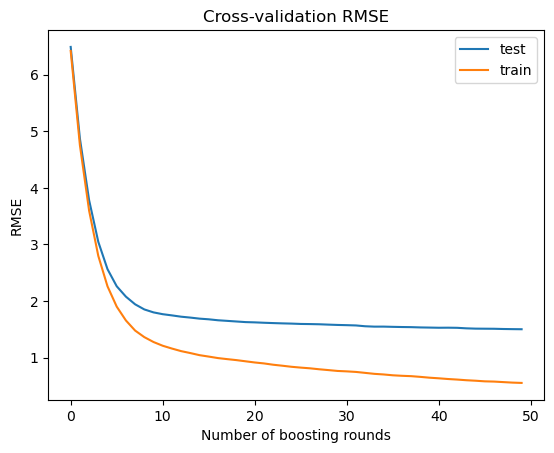

Cross-validated R^2: 0.9710301099562306


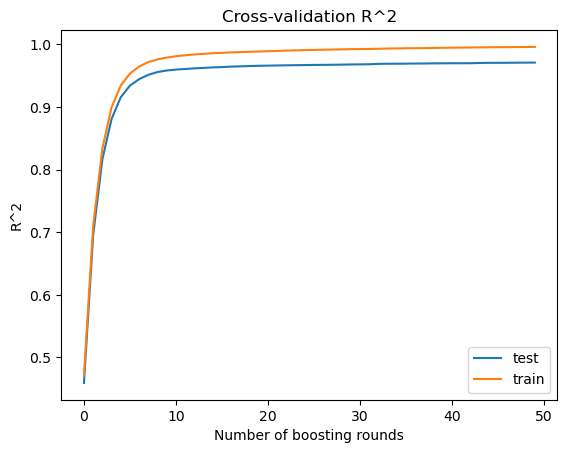

Cross validation MAE: 0.5944639620504851


In [15]:
# Do cross validation
from sklearn.model_selection import cross_val_score
import numpy

# cross validation
if(type(model) == xgb.core.Booster):
    scores = xgb.cv(params, dtrain, num_boost_round=50, nfold=4, early_stopping_rounds=10, metrics='rmse')
    print(f"Cross validation Rmse: {numpy.mean(scores)}")
    mean_rmse = scores["test-rmse-mean"].values[-1]
    r2_cv = 1 - (mean_rmse ** 2 / numpy.var(y_train))
    # plot the cross-validation rmse across the folds
    plt.plot(scores["test-rmse-mean"], label='test')
    plt.plot(scores["train-rmse-mean"], label='train')
    plt.xlabel('Number of boosting rounds')
    plt.ylabel('RMSE')
    plt.title('Cross-validation RMSE')
    plt.legend()
    plt.show()
    print(f"Cross-validated R^2: {r2_cv}")
    # plot the cross-validation r2 across the folds
    plt.plot(1 - (scores["test-rmse-mean"] ** 2 / numpy.var(y_train)), label='test')
    plt.plot(1 - (scores["train-rmse-mean"] ** 2 / numpy.var(y_train)), label='train')
    plt.xlabel('Number of boosting rounds')
    plt.ylabel('R^2')
    plt.title('Cross-validation R^2')
    plt.legend()
    plt.show()
    scores = xgb.cv(params, dtrain, num_boost_round=50, nfold=5, early_stopping_rounds=10, metrics='mae')
    print(f"Cross validation MAE: {numpy.mean(scores)}")
else:
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    print(f"Cross validation MSE: {numpy.mean(-scores)}")
    # plot mse across the folds
    plt.plot(-scores)
    plt.xlabel('Fold')
    plt.ylabel('MSE')
    plt.title('Cross-validation MSE')
    plt.show()
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    print(f"Cross validation R-sq: {numpy.mean(scores)}")
